## Predicting soil organic carbon from remote sensing images


### Part 1: Load and analyze data

In [1]:
## Import libraries
import geopandas as gp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import earthpy.spatial as es
import earthpy.plot as ep
import folium
import geojsonio
import rasterio
from shapely.geometry import Point
from osgeo import gdal, ogr, gdal_array
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from rasterio.plot import show, show_hist, reshape_as_raster, reshape_as_image
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Import dataset
dataset = pd.read_csv("dataset.csv", sep = ';')
dataset.head()

,X,Y,Clay.gkg,OM.gkg
0,-47.449435,-22.841908,503,25.02
1,-47.378210,-22.856072,120,15.00
2,-47.375972,-22.864430,128,8.00
3,-47.372973,-22.868192,117,11.00
4,-47.375876,-22.871974,112,12.00


In [3]:
## Create a new column calculating the percentage of carbon in OM
dataset['SOC.gkg'] = (dataset['OM.gkg'] * 0.58).round(2)
dataset.head()

,X,Y,Clay.gkg,OM.gkg,SOC.gkg
0,-47.449435,-22.841908,503,25.02,14.51
1,-47.378210,-22.856072,120,15.00,8.70
2,-47.375972,-22.864430,128,8.00,4.64
3,-47.372973,-22.868192,117,11.00,6.38
4,-47.375876,-22.871974,112,12.00,6.96


In [4]:
## A glimpse in the distributions
dataset.describe().T.style

,count,mean,std,min,25%,50%,75%,max
X,387.000000,-47.405792,0.028579,-47.457000,-47.429491,-47.402237,-47.384177,-47.345924
Y,387.000000,-22.865434,0.029631,-22.907360,-22.889036,-22.874511,-22.842631,-22.782421
Clay.gkg,387.000000,267.754522,161.458265,13.000000,124.000000,233.000000,419.000000,638.000000
OM.gkg,387.000000,18.591008,6.370714,5.800000,13.200000,17.900000,23.050000,39.000000
SOC.gkg,387.000000,10.782920,3.694919,3.360000,7.660000,10.380000,13.370000,22.620000


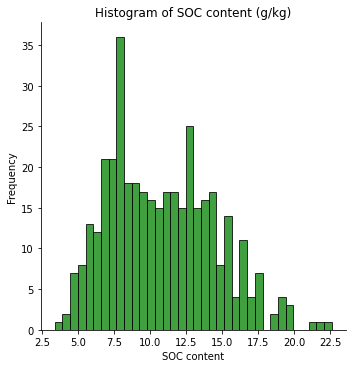

In [5]:
### Plotting histograms and density plots
sns.displot(dataset['SOC.gkg'], kind="hist", bins = int(180/5), color = 'green')
plt.title('Histogram of SOC content (g/kg)')
plt.xlabel('SOC content')
plt.ylabel('Frequency')
plt.show()

### Part 2: Convert to spatial objects, load geojson and plot

In [6]:
## Convert pandas dataframe into geopandas
geo_xy = [Point(xy) for xy in zip(dataset['X'], dataset['Y'])]
dataset_gp = gp.GeoDataFrame(dataset, crs = "EPSG:4326", geometry = geo_xy)
dataset_gp.head()

,X,Y,Clay.gkg,OM.gkg,SOC.gkg,geometry
0,-47.449435,-22.841908,503,25.02,14.51,POINT (-47.44944 -22.84191)
1,-47.378210,-22.856072,120,15.00,8.70,POINT (-47.37821 -22.85607)
2,-47.375972,-22.864430,128,8.00,4.64,POINT (-47.37597 -22.86443)
3,-47.372973,-22.868192,117,11.00,6.38,POINT (-47.37297 -22.86819)
4,-47.375876,-22.871974,112,12.00,6.96,POINT (-47.37588 -22.87197)


In [7]:
## Add geojson
area = gp.read_file("area.geojson")
area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

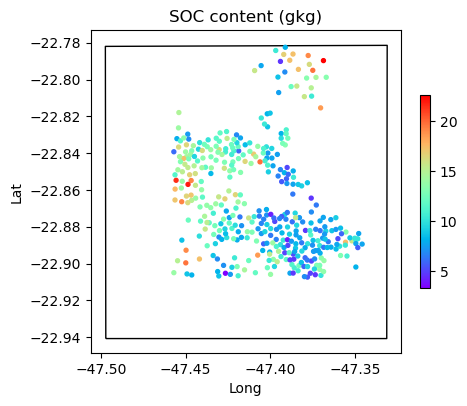

In [8]:
## Plot the points 
fig, ax = plt.subplots(figsize = (5, 5))
area.plot(ax=ax, color = 'white', edgecolor='black')
dataset_gp.plot(column = 'SOC.gkg', ax = ax, marker = 'o', markersize = 8, cmap = 'rainbow', legend = True, 
               legend_kwds = {'shrink': 0.5})
ax.set_title('SOC content (gkg)')
plt.xlabel('Long')
plt.ylabel('Lat')
plt.show()

In [9]:
## Plot in an interative base map to know where the 
coords = [-22.84, -47.4]
my_map = folium.Map(location = coords, zoom_start = 12)
folium.GeoJson(data=dataset_gp["geometry"]).add_to(my_map)
folium.GeoJson(data=area["geometry"]).add_to(my_map)
my_map

In [10]:
## Load rasters
covs = rasterio.open('covs.tif')
covs.shape

(886, 924)

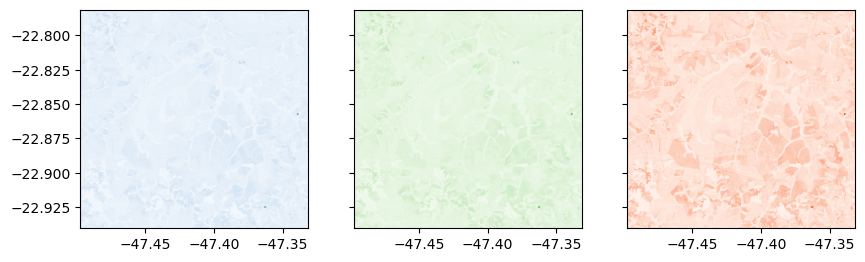

In [11]:
## Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10,10), sharey = True)

## Plot bands
show((covs, 1), cmap = 'Blues', ax=ax1)
show((covs, 2), cmap = 'Greens', ax=ax2)
show((covs, 3), cmap = 'Reds', ax=ax3)
plt.show()

(15, 886, 924)


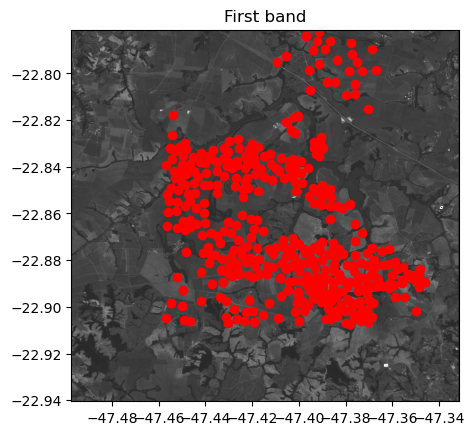

In [12]:
## RGB composite
#Read he grid values into numpy arrays
covs_arr = covs.read()
print(covs_arr.shape)

fig, ax = plt.subplots(figsize=(5,5))
dataset_gp.plot(ax=ax, color='red')
show(covs, ax=ax, cmap = 'RdGy_r')
plt.title('First band')
plt.show()

In [13]:
## Extract the raster values
dataset_gp.index = range(len(dataset_gp))
dataset_gp
coords = [(x,y) for x, y in zip(dataset_gp.X, dataset_gp.Y)]
dataset_gp['ju'] = [x for x in covs.sample(coords)]
dataset_gp.head()

,X,Y,Clay.gkg,OM.gkg,SOC.gkg,geometry,ju
0,-47.449435,-22.841908,503,25.02,14.51,POINT (-47.44944 -22.84191),"[378.83334, 652.5, 769.0, 1043.5, 1945.75, 219..."
1,-47.378210,-22.856072,120,15.00,8.70,POINT (-47.37821 -22.85607),"[529.0833, 812.3333, 1102.75, 1418.7778, 1962...."
2,-47.375972,-22.864430,128,8.00,4.64,POINT (-47.37597 -22.86443),"[605.0, 917.8, 1240.6666, 1590.0, 2259.5, 2497..."
3,-47.372973,-22.868192,117,11.00,6.38,POINT (-47.37297 -22.86819),"[651.8889, 972.6667, 1297.2, 1558.8, 2231.5, 2..."
4,-47.375876,-22.871974,112,12.00,6.96,POINT (-47.37588 -22.87197),"[634.0, 939.75, 1205.1666, 1529.3334, 2053.0, ..."


In [14]:
## Convert to pandas dataframe and separate the columns list
dataset_df = pd.DataFrame(dataset_gp)
dat_split = pd.DataFrame(dataset_df['ju'].tolist(), columns = ["blue", "green", "red", "r1", "r2", "r3", 'nir', 
                                                               '8A', "swir1", "swir2", "BSI", "CVI", "EVI", "NDRE", "NDVI"])
dataset_df = pd.concat([dataset_df, dat_split], axis=1)
dataset_df = dataset_df.drop(['geometry', 'ju', 'X', 'Y'], axis=1)  ## drop all the columns that will no be used

dataset_df.head()

,Clay.gkg,OM.gkg,SOC.gkg,blue,green,red,r1,r2,r3,nir,8A,swir1,swir2,BSI,CVI,EVI,NDRE,NDVI
0,503,25.02,14.51,378.833344,652.500000,769.000000,1043.500000,1945.750000,2194.750000,2198.333252,2350.500000,1671.333374,1035.75,-0.027271,3.970625,0.883410,0.356228,0.481690
1,120,15.00,8.70,529.083313,812.333313,1102.750000,1418.777832,1962.333374,2239.000000,2248.000000,2378.333252,2677.250000,2258.00,0.152952,3.756685,0.584836,0.226145,0.341789
2,128,8.00,4.64,605.000000,917.799988,1240.666626,1590.000000,2259.500000,2497.666748,2523.000000,2618.333252,2918.500000,2600.00,0.141504,3.716005,0.582709,0.226842,0.340714
3,117,11.00,6.38,651.888916,972.666687,1297.199951,1558.800049,2231.500000,2494.000000,2572.750000,2764.000000,3110.000000,2789.00,0.154951,3.527577,0.560728,0.245416,0.329604
4,112,12.00,6.96,634.000000,939.750000,1205.166626,1529.333374,2053.000000,2354.000000,2415.000000,2564.333252,2870.500000,2440.00,0.144100,3.295639,0.569773,0.224542,0.334193


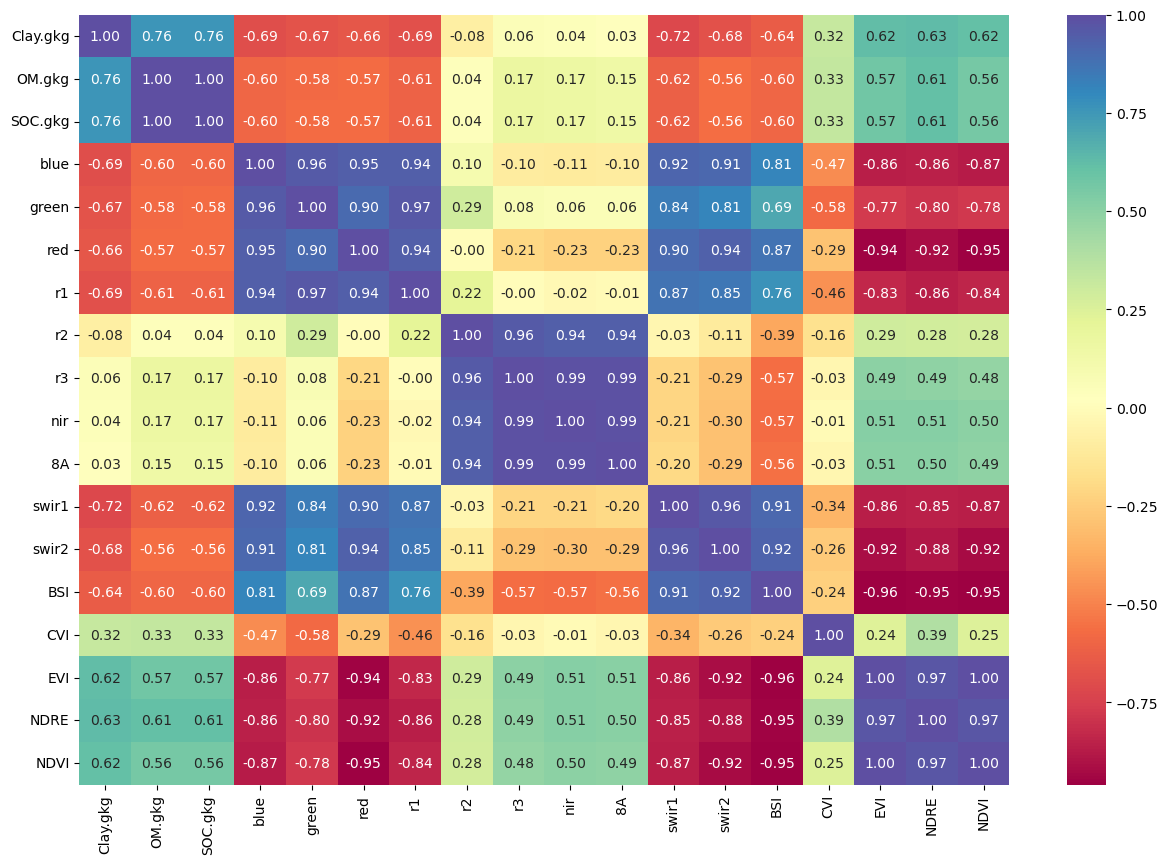

In [15]:
## Correlation analysis
dat_corr = dataset_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(dat_corr, cmap='Spectral', annot=True, fmt=".2f")
plt.show()

### Part 3: Build prediction model

In [16]:
## Random Forest
## Separating covariates (X) from the target (y) variable
X = dataset_df.drop(['Clay.gkg', 'OM.gkg', 'SOC.gkg'], axis =1)
y = dataset_df[['Clay.gkg', 'OM.gkg', 'SOC.gkg']]
## Splitting the data into training and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  random_state=12)

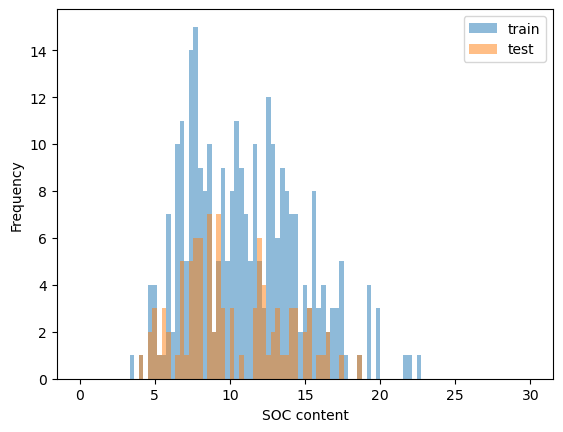

In [15]:
#Plot both datasets
bins = np.linspace(0, 30, 100)
plt.hist(y_train['SOC.gkg'],  bins, alpha=0.5, label='train')
plt.hist(y_test['SOC.gkg'], bins, alpha=0.5, label='test')
plt.legend(loc='upper right')
plt.xlabel('SOC content')
plt.ylabel('Frequency')
plt.show()


RMSE:  2.47 g/kg
Mean Absolute Error: 1.82 g/kg.
R-squared:  0.47


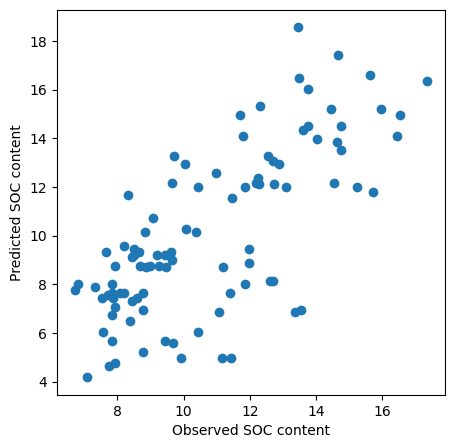

In [17]:
# Initializing the Random Forest Regression model with 500 decision trees for predicting clay content
model_rf = RandomForestRegressor(n_estimators = 500)

# Fitting the Random Forest Regression model to the data
model_rf.fit(x_train, y_train['SOC.gkg'])

# Predicting the target values of the test set
y_pred = model_rf.predict(x_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test['SOC.gkg'], y_pred)), '.2f'))
print("\nRMSE: ", rmse, 'g/kg')

# Calculate and print out the mean absolute error (mae)
errors = abs(y_pred - y_test['SOC.gkg'])
print('Mean Absolute Error:', round(np.mean(errors), 2), 'g/kg.')

# Calculate and print R-squared
r2 = r2_score(y_test['SOC.gkg'].values.ravel(), y_pred)
print('R-squared: ', round(r2, 2))

## Plotting the results
plt.figure(figsize=(5,5))
plt.scatter(y_pred, y_test['SOC.gkg'])
plt.xlabel('Observed SOC content')
plt.ylabel('Predicted SOC content')
plt.show()

In [18]:
## load image data
img_RS = 'covs.tif'

image = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((image.RasterYSize, image.RasterXSize, image.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(image.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = image.GetRasterBand(b + 1).ReadAsArray()
    

## Set the number of columns, rows and bands
rows = image.RasterYSize
cols = image.RasterXSize
bands = image.RasterCount

print('Image extent: {} x {} (row x col)'.format(rows, cols))
print('Number of Bands: {}'.format(bands))

Image extent: 886 x 924 (row x col)
Number of Bands: 15


In [19]:
## Reshape to (row*col, bands)
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :np.int(img.shape[2])].reshape(new_shape)
img_as_array.shape

(818664, 15)

In [20]:
## Predicting into the entire raster
soc_prediction = model_rf.predict(img_as_array)
soc_prediction = soc_prediction.reshape(img[:, :, 0].shape)
soc_prediction.shape

(886, 924)

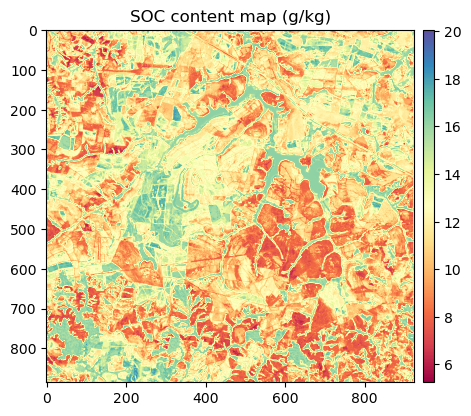

In [33]:
## Plotting the predicted map
fig, axs = plt.subplots(figsize=(5,5))
img = axs.imshow(soc_prediction, cmap = 'Spectral')
plt.title("SOC content map (g/kg)")
cbar = ep.colorbar(img)
plt.show()

In [ ]:
## Fim